# Inflammation map

Get inflammation meta analysis map in HCP (or DK?)

Paper: https://www.sciencedirect.com/science/article/pii/S014976341730893X?via%3Dihub

Data: https://neurovault.org/collections/3234/

In [8]:
# Import modules and R
import numpy as np, pandas as pd
from plotnine import *
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

In [74]:
import sys, os
sys.path.append('../code')
from processing_helpers import *
from analysis_helpers import *
from mri_maps import *
from gradientVersion import *
from pcaVersion import *
%R source("../code/Rplots.R");
%R source("../code/brainPlots.R");
%R source("../code/plot_maps.R");

In [1]:
from nilearn.input_data import NiftiLabelsMasker

/opt/conda/lib/python3.8/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
data_dir = "../data/parcellations/"
hcp_img = data_dir + "HCP-MMP_1mm.nii.gz"
mask = NiftiLabelsMasker(hcp_img, resampling_target='data')

In [105]:
# img = "../data/Activation_proportion.nii.gz"
img = "../data/Activation_FWE_extent_medium.nii.gz"
parcellated = mask.fit_transform(img).squeeze()

In [106]:
inflammation = (pd.DataFrame({'activation': parcellated})
                .set_axis([i+1 for i in range(360)])
                # .apply(lambda x: x-np.median(x))
                .join(get_labels_hcp())
                .rename({'label':'region'}, axis=1)
                .assign(hemi=lambda x:['left' if id<=180 else 'right' for id in x.index])
               )

array([[<AxesSubplot:title={'center':'activation'}>]], dtype=object)

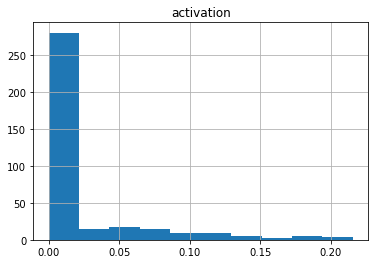

In [107]:
inflammation.hist()

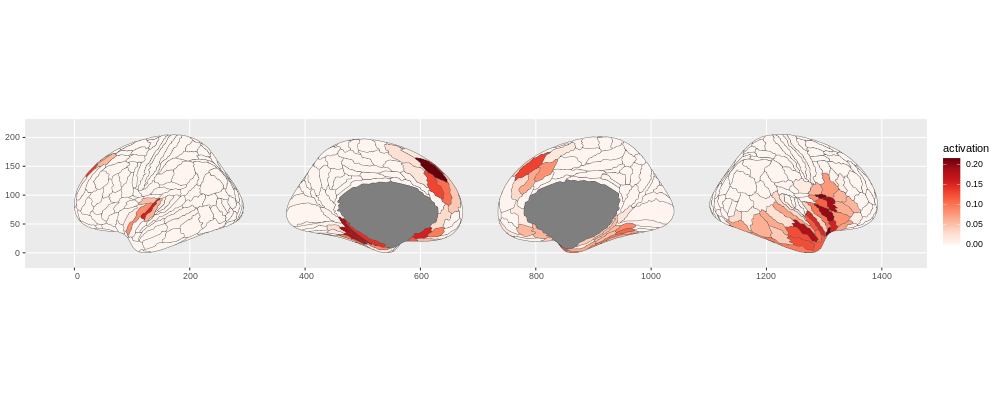

In [108]:
%%R -i inflammation -w 1000 -h 400
ggplot(inflammation, aes(fill=activation)) + 
geom_brain(atlas=glasser, aes(geometry=geometry, hemi=hemi, side=side, type=type)) +
scale_fill_gradientn(colors=brewer.reds(100))
# scale_fill_gradientn(colors=rev(brewer.rdbu(100)[1:60]))

Add inflammation?

In [118]:
(get_inflammation_data()[:180]
 .set_index('region').drop('hemi',axis=1)
 .apply(lambda x: (x-np.mean(x))/np.std(x))
 .rename({'activation':'Inflammation-Associated Activation'},axis=1)
 .to_csv("../data/inflammation_activation.csv")
)
maps = pd.read_csv("../data/inflammation_activation.csv", index_col=0)

In [114]:
maps = (get_inflammation_data("../data/Activation_FWE_extent_medium.nii.gz")[:180]
# maps = (get_inflammation_data("../data/inflammation_network_regions.nii.gz")[:180]
 .set_index('region').drop('hemi',axis=1)
 .apply(lambda x: (x-np.mean(x))/np.std(x))
 .rename({'activation':'Inflammation-Associated Activation'},axis=1)
 # .to_csv("../data/inflammation_activation.csv")
)
# maps = pd.read_csv("../data/inflammation_activation.csv", index_col=0)

In [112]:
dm_hcp_ds9 = gradientVersion(approach='dm', kernel='normalized_angle', alpha=1).fit('hcp_ds9')
scores = dm_hcp_ds9.clean_scores().iloc[:,:3].rename_axis('region')

New gradients version: method=dm, kernel=normalized_angle, data=hcp_ds9


In [115]:
get_corrs(scores, maps)

,G1,G2,G3
Inflammation-Associated Activation,-0.302493,0.06627,0.163944


In [104]:
get_corrs(scores, maps)

,G1,G2,G3
Inflammation-Associated Activation,-0.413743,-0.276724,0.151773


In [93]:
scores_plot = dm_hcp_ds9.clean_scores().assign(version='')

,0,1,2,3,4,label,version
label,,,,,,,
1,1.935910,-2.321273,1.490022,2.413845,1.091786,V1,
2,1.653984,-1.123203,0.843161,1.174303,0.243700,MST,
3,1.011170,0.042288,0.224958,0.508915,-0.198132,V6,
4,1.907302,-2.053052,1.128207,1.852764,0.777918,V2,
5,1.897689,-2.077655,0.851460,1.777768,0.433535,V3,
...,...,...,...,...,...,...,...
176,-1.086889,-0.544156,-0.975613,-0.089672,1.690916,STSva,
177,-0.966100,-0.289280,-1.215459,0.083591,1.853173,TE1m,
178,-1.416394,-1.286337,-0.284528,0.032399,1.319785,PI,


In [119]:
inf = maps.reset_index()

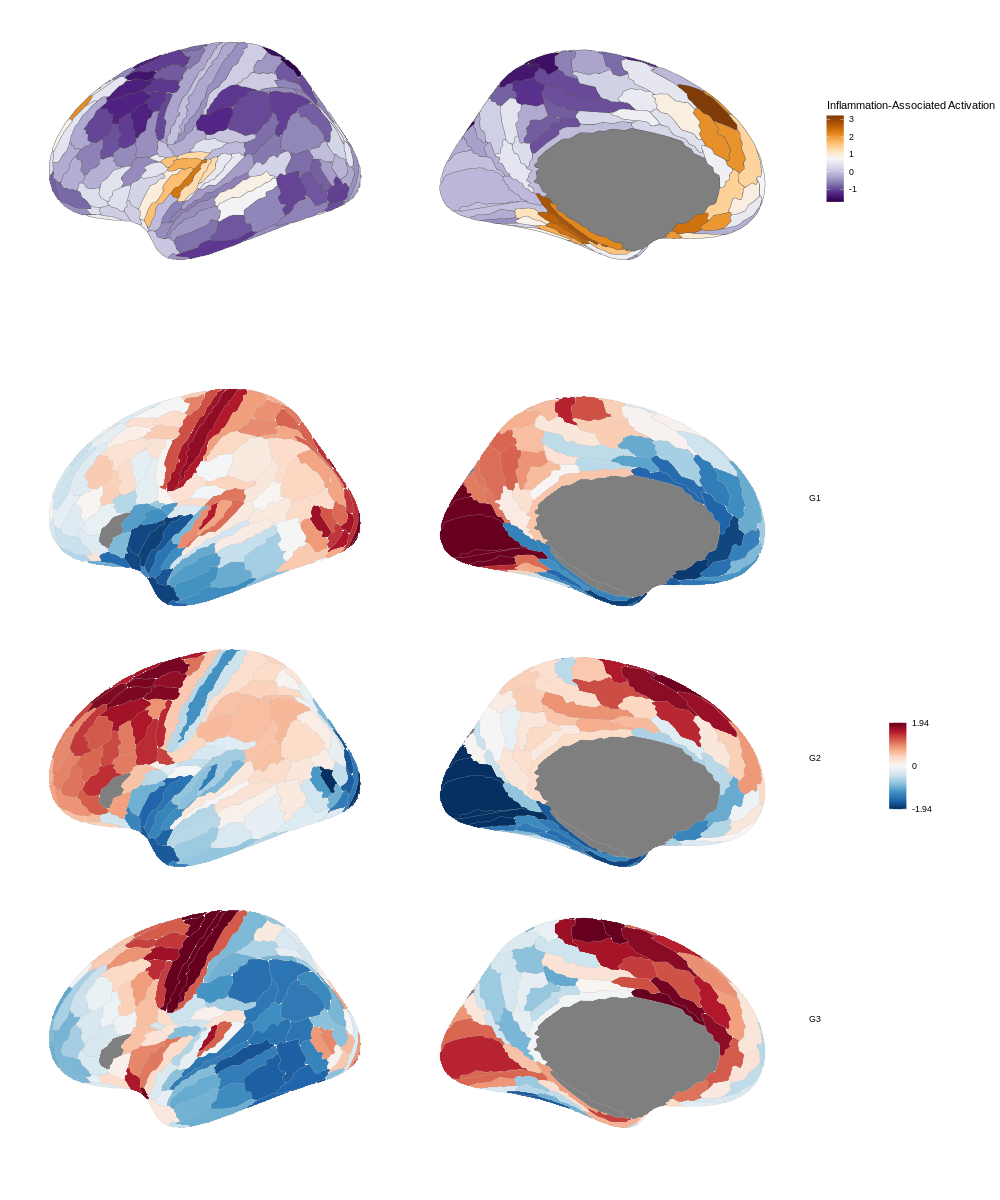

In [120]:
%%R -i inf -i scores_plot -w 1000 -h 1200
p1 <- ggplot(inf, aes(fill=`Inflammation-Associated Activation`)) + 
geom_brain(atlas=glasser, hemi='left', aes(geometry=geometry, hemi=hemi, side=side, type=type)) +
scale_fill_gradientn(colors=rev(brewer.puor(100))) + theme_void()

p2 <- plot_hcp(scores_plot, three=T) + theme(legend.position='right')

(p1 / p2) + plot_layout(heights=c(1,3))